In [51]:
import os
import numpy as np
import cv2
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import re
import pandas as pd
from skimage import measure
from scipy import ndimage

In [52]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [53]:
path = '/home/mr1142/Documents/Data/NIH/images_005'
val_names = os.listdir('/home/mr1142/Documents/Data/NIH/images_005/images')

In [54]:
path = '/home/mr1142/Documents/Data/NIH/Data_Entry_2017.csv'
pd.read_csv(path).head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


# Set de validación

In [55]:
# path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/patologic'

In [56]:
masks_name = [f for f in os.listdir(os.path.join(path, 'mascara')) 
              if os.path.isfile(os.path.join(os.path.join(path, 'mascara'), f))]

In [57]:
path = '/home/mr1142/Documents/Data/NIH/images_001/images'
masks_name = [f for f in os.listdir(os.path.join(path)) 
              if os.path.isfile(os.path.join(os.path.join(path), f))]

In [58]:
len(masks_name)

4999

In [59]:
pixels = 256

In [60]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end='')
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [61]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)
    # return img/np.max(img)

In [62]:
def binarize(img):
    img[img>0] = 1
    return img

# Preprocesado de imagen de entrada al modelo

In [63]:
modelos = os.listdir('/home/mr1142/Documents/Data/models')
modelos.sort()
modelos

['imagenes.h5', 'mascaras', 'neumonia', 'unsupervised.h5']

In [64]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [65]:
def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = ex.dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + 0.5*loss2
    return loss

In [66]:
def quitar_trozos(mask):
    mask = measure.label(mask)
    # regions = regionprops(all_labels)
    ntotal = {k: (k==mask).sum() for k in np.unique(mask) if k >0}
    print(ntotal)
    k = list(ntotal.keys())[np.argmax(list(ntotal.values()))]
    print(k)
    mask = k==mask
    mask = ndimage.binary_fill_holes(mask,structure=np.ones((5,5,1)))
    return mask

In [67]:
def apply_mask(img, mask):
    mask = quitar_trozos(mask > 0.5)
    return img * mask

# 1 canal

In [68]:
unet = keras.models.load_model('/home/mr1142/Documents/Data/models/mascaras/fine_tune_1.h5', 
                                     custom_objects={"MyLoss": MyLoss, 
                                                     "loss_mask": loss_mask, 
                                                     "dice_coef_loss": dice_coef_loss,
                                                     "dice_coef": dice_coef})

# Custom loss mejorada

In [69]:
uloss = keras.models.load_model('/home/mr1142/Documents/Data/models/mascaras/unet_final_renacimiento_validation_6.h5', 
                                     custom_objects={"MyLoss": MyLoss, 
                                                     "loss_mask": loss_mask, 
                                                     "dice_coef_loss": dice_coef_loss,
                                                     "dice_coef": dice_coef})

In [70]:
r = 0

In [71]:
un = 0
ul = 0

{1: 27518, 2: 41}
1
{1: 27748}
1


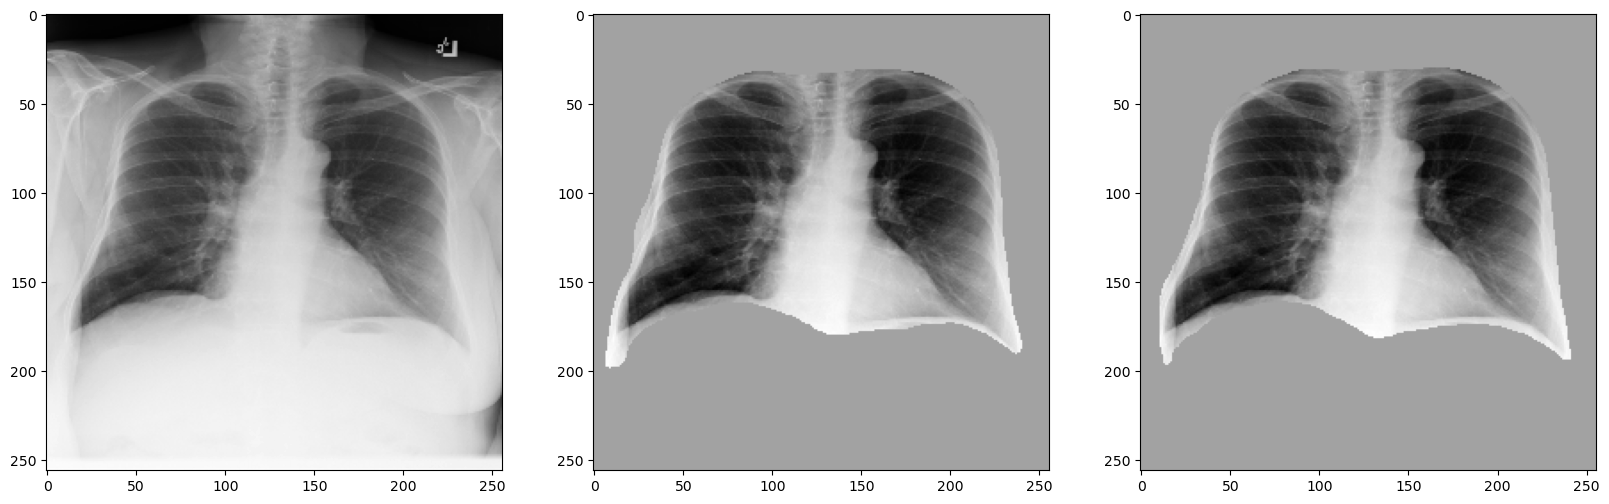

In [107]:
# r = np.random.randint(0, len(masks_name))
img = normalize(read_img(path, '', masks_name[r]))
net_mask = unet.predict(img[np.newaxis,...])[0,...]
loss_mask = uloss.predict(img[np.newaxis,...])[0,...]

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(apply_mask(img, net_mask), cmap = 'gray')
# plt.imshow(apply_mask(img, loss_mask), cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, loss_mask), cmap = 'gray')
# plt.imshow(apply_mask(img, net_mask), cmap = 'gray')
plt.show()
r += 1

In [73]:
r

1

In [74]:
ul += 1
ul

1

In [75]:
un += 1
un

1

# Ver los agujeros

In [76]:
datos = {}

In [453]:
path = '/home/mr1142/Documents/Data/patologic/images'
images = [f for f in os.listdir(path) 
              if os.path.isfile(os.path.join(path, f))]

In [454]:
len(images)

200

In [9]:
r = np.random.randint(0,len(images), 500)
images = [images[i] for i in r]

In [10]:
len(images)

500

In [455]:
models = [model for model in modelos if bool(re.search('renacimiento', model))]+[model for model in modelos if bool(re.search('new', model))]

In [457]:
models = [model for model in models if not bool(re.search('fine_tuning', model))]

In [458]:
models

['uloss_final_renacimiento_validation_6.h5',
 'uloss_final_renacimiento_validation_8.h5',
 'uloss_renacimiento_validation_2.h5',
 'uloss_renacimiento_validation_3.h5',
 'uloss_renacimiento_validation_4.h5',
 'unet_final_renacimiento_validation_5.h5',
 'unet_final_renacimiento_validation_6.h5',
 'unet_final_renacimiento_validation_7.h5',
 'unet_final_renacimiento_validation_8.h5',
 'unet_renacimiento_validation_1.h5',
 'unet_renacimiento_validation_2.h5',
 'unet_renacimiento_validation_3.h5',
 'unet_renacimiento_validation_4.h5',
 'uloss_new_segmentation_2.h5',
 'uloss_new_segmentation_3.h5',
 'uloss_new_segmentation_5.h5',
 'uloss_new_segmentation_6.h5',
 'uloss_new_segmentation_7.h5',
 'uloss_new_segmentation_8.h5',
 'unet_new_segmentation_1.h5',
 'unet_new_segmentation_2.h5',
 'unet_new_segmentation_3.h5',
 'unet_new_segmentation_7.h5',
 'unet_new_segmentation_8.h5']

In [459]:
for i, modelo in enumerate(models):
    print(modelo)
    datos[modelo] = []
    p = os.path.join('/home/mr1142/Documents/Data/models', modelo)
    model = keras.models.load_model(p, 
                                     custom_objects={"MyLoss": MyLoss, 
                                                     "loss_mask": loss_mask, 
                                                     "dice_coef_loss": dice_coef_loss,
                                                     "dice_coef": dice_coef})
    for image in images:
        img = normalize(read_img(path, '', image))
        mask = model.predict(img[np.newaxis,...])[0,...]
        mask = measure.label(mask)
        datos[modelo].append(len(np.unique(mask))-1)
    print('{}%'.format(i/len(models)*100))

uloss_final_renacimiento_validation_6.h5
0.0%
uloss_final_renacimiento_validation_8.h5
4.166666666666666%
uloss_renacimiento_validation_2.h5
8.333333333333332%
uloss_renacimiento_validation_3.h5
12.5%
uloss_renacimiento_validation_4.h5
16.666666666666664%
unet_final_renacimiento_validation_5.h5
20.833333333333336%
unet_final_renacimiento_validation_6.h5
25.0%
unet_final_renacimiento_validation_7.h5
29.166666666666668%
unet_final_renacimiento_validation_8.h5
33.33333333333333%
unet_renacimiento_validation_1.h5
37.5%
unet_renacimiento_validation_2.h5
41.66666666666667%
unet_renacimiento_validation_3.h5
45.83333333333333%
unet_renacimiento_validation_4.h5
50.0%
uloss_new_segmentation_2.h5
54.166666666666664%
uloss_new_segmentation_3.h5
58.333333333333336%
uloss_new_segmentation_5.h5
62.5%
uloss_new_segmentation_6.h5
66.66666666666666%
uloss_new_segmentation_7.h5
70.83333333333334%
uloss_new_segmentation_8.h5
75.0%
unet_new_segmentation_1.h5
79.16666666666666%
unet_new_segmentation_2.h5
83

In [460]:
df = pd.DataFrame(datos)
df = df.transpose()

In [461]:
df['incorrectas'] = [np.sum(df.loc[model] > 1) for model in list(df.index)]
df['media'] = [np.mean(df.loc[model]) for model in list(df.index)]
df['type'] = [list(re.split('_', model))[0] for model in list(df.index)]

In [97]:
df = df.drop(labels=['unet3.h5', 'unet_nuevos_validation_oldest_1.h5', 'unet_1.h5', 'unet_2.h5', 'unet_3.h5'], axis=0)

In [462]:
df.sort_values('incorrectas')

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,incorrectas,media,type
uloss_new_segmentation_5.h5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0.995025,uloss
unet_final_renacimiento_validation_6.h5,1,1,1,1,1,1,1,1,1,1,...,1,1,2,1,1,3,1,19,1.238806,unet
unet_renacimiento_validation_2.h5,1,1,1,1,1,1,1,1,1,2,...,1,1,1,1,1,1,1,20,1.203980,unet
uloss_final_renacimiento_validation_8.h5,2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,2,21,1.228856,uloss
uloss_final_renacimiento_validation_6.h5,1,1,1,1,1,1,1,2,1,1,...,1,1,1,2,1,1,2,23,1.288557,uloss
unet_new_segmentation_7.h5,6,1,1,1,1,1,1,1,3,1,...,1,1,5,1,1,1,1,25,1.398010,unet
unet_new_segmentation_2.h5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,3,26,1.323383,unet
unet_renacimiento_validation_1.h5,1,1,1,1,1,1,1,1,1,1,...,1,1,2,1,1,1,4,26,1.358209,unet
unet_final_renacimiento_validation_8.h5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,2,1,26,1.323383,unet
unet_new_segmentation_8.h5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,4,27,1.353234,unet


In [463]:
np.mean(df[df.type == 'unet']['media'])

1.4102564102564101

In [464]:
np.mean(df[df.type == 'uloss']['media'])

7.906377204884668

In [465]:
lab = 'media'

(1.7213930348258708, 1.1721393034825869)

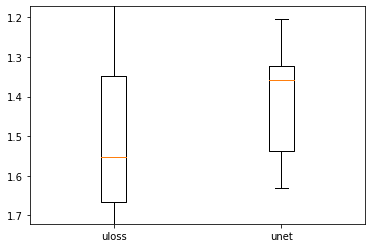

In [466]:
plt.boxplot([df[df.type == 'uloss'][lab], df[df.type == 'unet'][lab]], labels = ['uloss', 'unet'])
q1, q3 = np.percentile(df[lab], [20, 80])
r = q1-q3
plt.ylim(q1-1.5*r, q3+1.5*r)

In [106]:
df.to_csv('/home/mr1142/Documents/Data/models/validation_results/imagenes_incorrectas.csv')

# Aplicacion en serie

In [770]:
def des_normalize(img):
    return cv2.normalize(img, None, alpha = 0, beta = 255,
                         norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

In [783]:
path = '/home/mr1142/Documents/Data/validacion_medica/NIH'

In [784]:
images = [f for f in os.listdir(path) if bool(re.search('png', f))]

In [785]:
len(images)

200

In [786]:
model = uloss

In [787]:
for image in images:
    img = normalize(read_img(path,'', image))
    mask = model.predict(img[np.newaxis,...])[0,...]
    segmented = des_normalize(apply_mask(img, mask))    
    cv2.imwrite(os.path.join(path,'mascara', image), segmented)

{1: 26308}
1
{1: 30745}
1
{1: 30562}
1
{1: 24165}
1
{1: 30333}
1
{1: 28419}
1
{1: 30601}
1
{1: 28980, 2: 45}
1
{1: 25490}
1
{1: 21443}
1
{1: 21924, 2: 2}
1
{1: 24617}
1
{1: 26173}
1
{1: 22881}
1
{1: 30483}
1
{1: 24476}
1
{1: 30520}
1
{1: 33366, 2: 11, 3: 4}
1
{1: 20661}
1
{1: 24239, 2: 9, 3: 8, 4: 1, 5: 3}
1
{1: 25851}
1
{1: 23900}
1
{1: 24176}
1
{1: 29285}
1
{1: 26734}
1
{1: 26298}
1
{1: 19106}
1
{1: 19347}
1
{1: 32598}
1
{1: 20569}
1
{1: 30107}
1
{1: 28340}
1
{1: 30761}
1
{1: 25185}
1
{1: 23443}
1
{1: 14704}
1
{1: 21066}
1
{1: 31318}
1
{1: 27189}
1
{1: 24210}
1
{1: 31026, 2: 1}
1
{1: 30421}
1
{1: 24017}
1
{1: 25028}
1
{1: 29147}
1
{1: 33204}
1
{1: 37590}
1
{1: 21726}
1
{1: 38374}
1
{1: 20814, 2: 2024, 3: 2118, 4: 14, 5: 1, 6: 1}
1
{1: 23103}
1
{1: 37600}
1
{1: 24987}
1
{1: 21552}
1
{1: 23932}
1
{1: 27589}
1
{1: 22024}
1
{1: 30426}
1
{1: 21590}
1
{1: 25418}
1
{1: 33000, 2: 5, 3: 1}
1
{1: 25026}
1
{1: 31464}
1
{1: 28223}
1
{1: 22164}
1
{1: 23650}
1
{1: 23763}
1
{1: 20562, 2: 2, 3: 8, 4

In [777]:
names = os.listdir(os.path.join(path, 'mascara'))
len(names)

200

In [1002]:
p = '/home/mr1142/Documents/Data/NIH/Data_Entry_2017.csv'

In [1003]:
df = pd.read_csv(p)

In [1004]:
index = [i for i in df.index if df['Image Index'][i] in names]

In [1005]:
df = df.iloc[index]

In [1006]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
275,00000061_011.png,Effusion,11,61,77,M,AP,3056,2524,0.139,0.139,NaN
1424,00000372_002.png,Pneumothorax,2,372,80,M,AP,2500,2048,0.168,0.168,NaN
2967,00000792_001.png,No Finding,1,792,60,M,PA,2992,2991,0.143,0.143,NaN
3001,00000798_013.png,No Finding,13,798,65,F,AP,2500,2048,0.168,0.168,NaN
3172,00000831_005.png,No Finding,5,831,25,M,AP,2500,2048,0.168,0.168,NaN


In [1007]:
len(df)

200

In [1008]:
df.to_csv(os.path.join(path,'validation_data.csv'))